# Galaxy Classification with Efficient Vision Transformer (Pytorch)

**Vision Transformer (Linformer) repository on GitHub**:

1. https://github.com/lucidrains/vit-pytorch

2. https://github.com/lucidrains/linformer


Data:

https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge


References:

1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

2. https://pytorch.org/vision/stable/models.html

3. https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

4. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

5. https://cs231n.github.io/transfer-learning/

6. https://github.com/joshualin24/vit-pytorch/blob/main/examples/galaxy_classification.ipynb



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-318196b9-0439-3652-21f8-eba6e6188681)


## Install Vision Transformer (ViT)

In [2]:
! pip -q install vit_pytorch linformer

## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# vision transformer
from linformer import Linformer
from vit_pytorch.efficient import ViT as Efficient_ViT
from vit_pytorch import ViT

from einops import rearrange, repeat

cuda:0


In [4]:
torch.manual_seed(0)

## Unzip images


In [5]:
## The unzipping function
def unzipping(zip_file_name, dest_dir):
    """
    Arguments
        zip_file_name: (str) the file name of the zip file
        dest_dir: (str) the name of the destination folder
    """
    # check if the destination folder exists. Create one if not.
    #if not os.path.exists(dest_dir):
    #    os.makedirs(dest_dir)
    
    # unzipping
    zip_f = zipfile.ZipFile(zip_file_name, 'r')
    zip_f.extractall(path=dest_dir)
    zip_f.close()

#### Unzip from Google Drive

In [6]:
## directory on Google Drive
datasets_dir = 'drive/MyDrive/gz2_datasets'

## Unzip training, validation, and test images
unzipping(os.path.join(datasets_dir, 'images_train.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_valid.zip'), './')
unzipping(os.path.join(datasets_dir, 'images_test.zip'), './')

## Custom Datasets

In [7]:
## Custom Galaxy Zoo 2 Dataset
class GalaxyZooDataset(Dataset):
    """Galaxy Zoo Dataset"""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            images_dir (string): path to the dir containing all images
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.labels_df = self.labels_df[['galaxyID', 'label1']].copy()

        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        """
        Returns the size of the dataset
        """
        return len(self.labels_df)

    def __getitem__(self, idx):
        """
        Get the idx-th sample.
		Outputs the image (channel first) and the true label
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # galaxy ID
        galaxyid = self.labels_df.iloc[idx, 0].astype(str)
		# path of the image
        image_path = os.path.join(self.images_dir, galaxyid + '.jpg')
		# read the image
        image = Image.open(image_path)
		# apply transform (optional)
        if self.transform is not None:
            image = self.transform(image)
		# read the true label
        label = int(self.labels_df.iloc[idx, 1])

        return image, label, int(galaxyid)

## Custom Transforms

In [8]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.094, 0.0815, 0.063], [0.1303, 0.11, 0.0913])])

    
    return train_transform, valid_transform, test_transform

## Create dataloaders

In [9]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


### Function for model evaluation

In [8]:
def evaluate_model(model, device):
    """
    Evaluate the model on the test data
    """

    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_label = []

    for images, labels, galaxy_id in test_loader:
        images = images.to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            pred_logits = model(images)
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_label += torch.squeeze(galaxy_id.cpu()).tolist()
    
    # create a DataFrame with columns 'GalaxyID', 'class', 'predicted labels'
    predict_df = pd.DataFrame(data={'GalaxyID': y_label, 'class': y_true, 'pred': y_pred})

    # galaxy classes
    gxy_labels = ['Round Elliptical',
                    'In-between Elliptical',
                    'Cigar-shaped Elliptical',
                    'Edge-on Spiral',
                    'Barred Spiral',
                    'Unbarred Spiral',
                    'Irregular',
                    'Merger']
    
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=gxy_labels, columns=gxy_labels)

    # accuracy of each class
    for c in range(8):
        print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), gxy_labels[c]))
    print("================")

    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Total Accuracy = {:.4f}\n".format(acc))

    # recall
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall = {:.4f}\n".format(recall))

    # f1 score
    F1 = f1_score(y_true, y_pred, average='macro')
    print("F1 score = {:.4f}\n".format(F1))

    # plot confusion matrix
    sns.set(font_scale=1.6)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
    plt.show()

## Extract features from Vision Transformer

### ViT - Hyperparameters

In [21]:
"""
Parameters for ViT (Model 110421)
"""
PATCH_SIZE = 16
DEPTH = 8
HIDDEN_DIM = 256
MLP_DIM = 64
NUM_HEADS = 8
DROPOUT = 0.1
EMB_DROPOUT = 0.1

# loss calculation for each class
#class_weights = torch.FloatTensor([1., 1., 2., 1., 1., 1., 4., 3.]).to(device)
#class_weights = torch.FloatTensor([4.6, 4.0, 20.9, 9.6, 7.7, 5.1, 26.5, 73.3]).to(device)
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1.]).to(device)

### ViT - Create model

In [22]:
## Vision Transformer
model = ViT(image_size = 224,
            patch_size = PATCH_SIZE,
            num_classes = 8,
            dim = HIDDEN_DIM,
            depth = DEPTH,
            heads = NUM_HEADS,
            mlp_dim = MLP_DIM,
            dropout = DROPOUT,
            emb_dropout = EMB_DROPOUT)

# print out model details
print("Vision Transformer Model")
print("===============================")
print("patch_size = {}".format(PATCH_SIZE))
print("depth = {}".format(DEPTH))
print("dim = {}".format(HIDDEN_DIM))
print("mlp_dim = {}".format(MLP_DIM))
print("num_heads = {}".format(NUM_HEADS))
print("dropout = {}".format(DROPOUT))
print("emb_dropout = {}".format(EMB_DROPOUT))
print("batch_size = {}".format(BATCH_SIZE))
print("class weights = {}".format(class_weights))
print("===============================")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("===============================")

Vision Transformer Model
patch_size = 16
depth = 8
dim = 256
mlp_dim = 64
num_heads = 8
dropout = 0.1
emb_dropout = 0.1
batch_size = 64
class weights = tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Number of trainable parameters: 4719368


### ViT - Load pretrained weights

In [23]:
pth_filename = 'gz2_vit_110421.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

<All keys matched successfully>

### ViT - Check performance

Class 0: accuracy = 0.9076 (Round Elliptical)
Class 1: accuracy = 0.8772 (In-between Elliptical)
Class 2: accuracy = 0.7213 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.8956 (Edge-on Spiral)
Class 4: accuracy = 0.7968 (Barred Spiral)
Class 5: accuracy = 0.7338 (Unbarred Spiral)
Class 6: accuracy = 0.3827 (Irregular)
Class 7: accuracy = 0.5381 (Merger)
Total Accuracy = 0.8166

Recall = 0.7316

F1 score = 0.7418



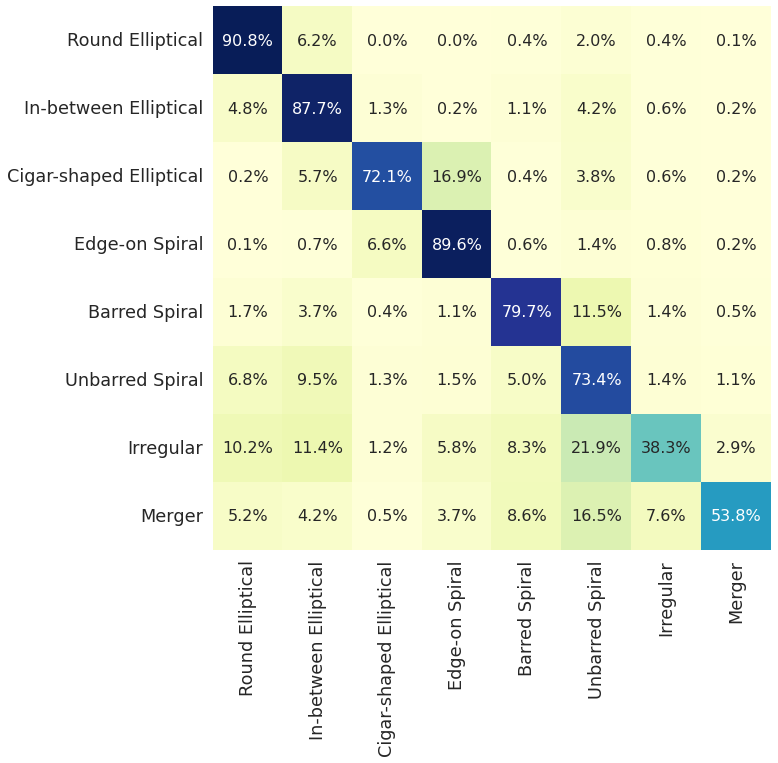

In [24]:
evaluate_model(model, device)

### ViT - Feature extraction

In [25]:
def vit_extract_features(model, data_loader):
    """
    Extract the features from vit/linformer
    """
    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_ids = []
    y_labels = []
    y_feature_vectors = []

    for images, labels, galaxy_id in data_loader:
        images = images.to(device)
        labels = labels.long().to(device)
        with torch.no_grad():
            x = model.to_patch_embedding(images)
            b, n, _ = x.shape
            cls_tokens = repeat(model.cls_token, '() n d -> b n d', b = b)
            x = torch.cat((cls_tokens, x), dim=1)
            x += model.pos_embedding[:, :(n + 1)]
            x = model.transformer(x)
            x = x.mean(dim = 1) if model.pool == 'mean' else x[:, 0]
            x = model.to_latent(x)
            x = model.mlp_head[0](x).detach().cpu().tolist()

            # append to outputs
            y_ids.extend(galaxy_id.cpu().tolist())
            y_labels.extend(labels.cpu().tolist())
            y_feature_vectors.extend(x)
            
    df = pd.DataFrame({'galaxy_id': y_ids, 'label': y_labels, 'features': y_feature_vectors})
    
    for j in range(HIDDEN_DIM):
        df["x"+str(j+1)] = df['features'].apply(lambda x: x[j])
    
    df = df.drop(columns=['features'])

    return df

In [26]:
## Extract features
vit_train_f256 = vit_extract_features(model, train_loader)
vit_valid_f256 = vit_extract_features(model, valid_loader)
vit_test_f256 = vit_extract_features(model, test_loader)

In [29]:
## Save to csv files
vit_train_f256.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_train_f256.csv'), index=False)
vit_valid_f256.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_valid_f256.csv'), index=False)
vit_test_f256.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'vit_test_f256.csv'), index=False)

In [30]:
del model

## Extract features from Linformer

### Lin - Hyperparameters

In [31]:
"""
Parameters
"""
PATCH_SIZE = 28
DEPTH = 12
HIDDEN_DIM = 128
K_DIM = 64
NUM_HEADS = 8
LIN_DROPOUT = 0.1

# loss calculation for each class
#class_weights = torch.FloatTensor([1., 1., 2., 1., 1., 1., 4., 3.]).to(device)
#class_weights = torch.FloatTensor([4.6, 4.0, 20.9, 9.6, 7.7, 5.1, 26.5, 73.3]).to(device)
class_weights = torch.FloatTensor([1., 1., 1., 1., 1., 1., 1., 1.]).to(device)

### Lin - Create model

In [35]:
# calculate seq_len
seq_len = int((224/PATCH_SIZE)**2) + 1

## Linformer
lin = Linformer(dim=HIDDEN_DIM, seq_len=seq_len, depth=DEPTH, k=K_DIM, heads=NUM_HEADS,
                dim_head=None, one_kv_head=False, share_kv=False, reversible=False, dropout=LIN_DROPOUT)

## Vision Transformer
model = Efficient_ViT(image_size=224, patch_size=PATCH_SIZE, num_classes=8, dim=HIDDEN_DIM, transformer=lin, pool='cls', channels=3)

# print out model details
print("Linformer Model")
print("===============================")
print("patch_size = {}".format(PATCH_SIZE))
print("depth = {}".format(DEPTH))
print("hidden_dim = {}".format(HIDDEN_DIM))
print("k_dim = {}".format(K_DIM))
print("num_heads = {}".format(NUM_HEADS))
print("dropout = {}".format(LIN_DROPOUT))
print("batch_size = {}".format(BATCH_SIZE))
print("class weights = {}".format(class_weights))
print("===============================")
print("Number of trainable parameters: {}".format(sum(param.numel() for param in model.parameters() if param.requires_grad)))
print("===============================")

Linformer Model
patch_size = 28
depth = 12
hidden_dim = 128
k_dim = 64
num_heads = 8
dropout = 0.1
batch_size = 64
class weights = tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Number of trainable parameters: 2785416


### Lin - Load pretrained weights

In [36]:
pth_filename = 'gz2_vit_09172021_0000_cache.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

<All keys matched successfully>

### Lin - Check performance

Class 0: accuracy = 0.9073 (Round Elliptical)
Class 1: accuracy = 0.8637 (In-between Elliptical)
Class 2: accuracy = 0.6873 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.8917 (Edge-on Spiral)
Class 4: accuracy = 0.7833 (Barred Spiral)
Class 5: accuracy = 0.7089 (Unbarred Spiral)
Class 6: accuracy = 0.4133 (Irregular)
Class 7: accuracy = 0.5307 (Merger)
Total Accuracy = 0.8055

Recall = 0.7233

F1 score = 0.7323



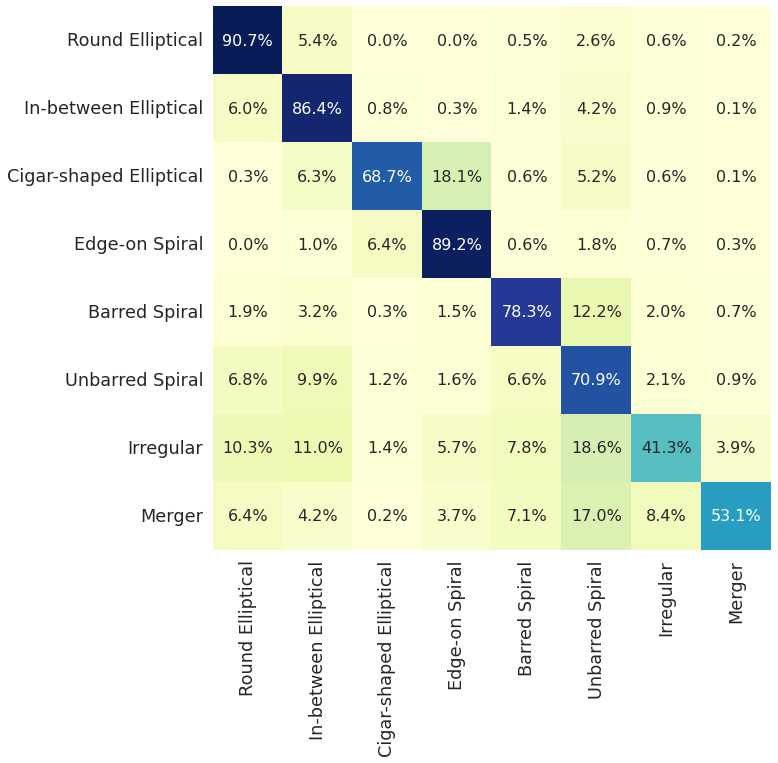

In [37]:
evaluate_model(model, device)

### Lin - Feature extraction

In [38]:
## Extract features
lin_train_f128 = vit_extract_features(model, train_loader)
lin_valid_f128 = vit_extract_features(model, valid_loader)
lin_test_f128 = vit_extract_features(model, test_loader)

In [39]:
## Save to csv files
lin_train_f128.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'lin_train_f128.csv'), index=False)
lin_valid_f128.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'lin_valid_f128.csv'), index=False)
lin_test_f128.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'lin_test_f128.csv'), index=False)

In [40]:
del model

## Extract features from ResNet-50

### Resnet - Custom Transforms

In [9]:
def create_data_transforms(is_for_inception=False):
    """
    Create Pytorch data transforms for the GalaxyZoo datasets.
    Args:
        is_for_inception (bool): True for inception neural networks
    Outputs:
        train_transform: transform for the training data
        test_transform: transform for the testing data
    """
    if is_for_inception:
        input_size = 299
    else:
        input_size = 224

    # transforms for training data
    train_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.RandomRotation(90),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for validation data
    valid_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # transforms for test data
    test_transform = transforms.Compose([transforms.CenterCrop(input_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    
    return train_transform, valid_transform, test_transform

### Resnet - Data loaders

In [10]:
"""
Data Loader
"""
# the batch size
BATCH_SIZE = 64

# create transforms
train_transform, valid_transform, test_transform = create_data_transforms(is_for_inception=False)

# create datasets
data_train = GalaxyZooDataset('gz2_train.csv', 'images_train', train_transform)
data_valid = GalaxyZooDataset('gz2_valid.csv', 'images_valid', valid_transform)
data_test = GalaxyZooDataset('gz2_test.csv', 'images_test', test_transform)

# dataloaders
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

# check the sizes
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_valid), len(valid_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("===============================")

**Dataloaders**
Number of training data: 99808 (1560 batches)
Number of validation data: 24952 (390 batches)
Number of test data: 31191 (488 batches)


### Resnet - Create model

In [11]:
## Download the pre-trained resnet50 model
model = models.resnet50(pretrained=True)

# change the last fc layer
model.fc = nn.Linear(2048, 8)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Resnet - Load pretrained weights

In [12]:
pth_filename = 'gz2_resnet50_A.pth'
model.load_state_dict(torch.load(os.path.join('drive/MyDrive/gz2_datasets', pth_filename)))

<All keys matched successfully>

### Resnet - Check performance

Class 0: accuracy = 0.9349 (Round Elliptical)
Class 1: accuracy = 0.8929 (In-between Elliptical)
Class 2: accuracy = 0.7437 (Cigar-shaped Elliptical)
Class 3: accuracy = 0.9144 (Edge-on Spiral)
Class 4: accuracy = 0.8481 (Barred Spiral)
Class 5: accuracy = 0.7939 (Unbarred Spiral)
Class 6: accuracy = 0.5425 (Irregular)
Class 7: accuracy = 0.6658 (Merger)
Total Accuracy = 0.8558

Recall = 0.7920

F1 score = 0.8007



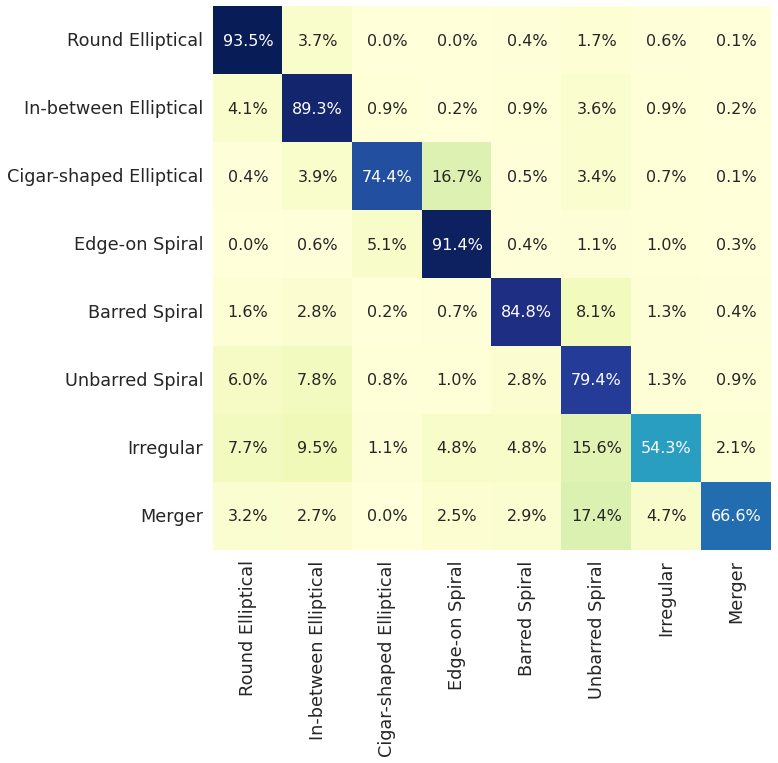

In [13]:
evaluate_model(model, device)

### Resnet - Feature extraction

In [14]:
# edit the last layer to output features
model.fc = nn.Flatten()

In [15]:
def resnet50_extract_features(model, data_loader):
    """
    Extract the features from Resnet-50
    """
    # move to gpu
    model = model.to(device)

    # evaluation
    model.eval()

    # empty lists for results
    y_ids = []
    y_labels = []
    y_feature_vectors = []

    for images, labels, galaxy_id in data_loader:
        images = images.to(device)
        labels = labels.long().to(device)
        with torch.no_grad():
            x = model(images)

            # append to results
            y_ids.extend(galaxy_id.cpu().tolist())
            y_labels.extend(labels.cpu().tolist())
            y_feature_vectors.extend(x.cpu().tolist())
            
    df = pd.DataFrame({'galaxy_id': y_ids, 'label': y_labels, 'features': y_feature_vectors})
    
    for j in range(2048):
        df["x"+str(j+1)] = df['features'].apply(lambda x: x[j])
    
    df = df.drop(columns=['features'])

    return df

In [17]:
## Extract features
res_test_f2048 = resnet50_extract_features(model, test_loader)
## Save to csv files
res_test_f2048.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'res_test_f2048.csv'), index=False)

In [19]:
## Extract features
res_valid_f2048 = resnet50_extract_features(model, valid_loader)
## Save to csv files
res_valid_f2048.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'res_valid_f2048.csv'), index=False)

In [ ]:
## Extract features
res_train_f2048 = resnet50_extract_features(model, train_loader)
## Save to csv files
res_train_f2048.to_csv(os.path.join('drive/MyDrive/gz2_datasets/features', 'res_train_f2048.csv'), index=False)